# **Tweet Classifier**

## Import Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import warnings
import pprint
pp = pprint.PrettyPrinter(depth=4)
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['font.size'] = 12


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Dataset


In [3]:
# Clone the Repo form the github and access the dataset
! git clone https://github.com/SyedDaniyalHassan/Tweets-Classifiee.git

Cloning into 'Tweets-Classifiee'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 3), reused 15 (delta 1), pack-reused 0
Receiving objects: 100% (20/20), 41.18 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (5/5), done.


In [4]:
df = pd.read_csv('/content/Tweets-Classifiee/TruthSeeker2023/Truth_Seeker_Model_Dataset.csv')
df.head()

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               134198 non-null  int64  
 1   author                   134198 non-null  object 
 2   statement                134198 non-null  object 
 3   target                   134198 non-null  bool   
 4   BinaryNumTarget          134198 non-null  float64
 5   manual_keywords          134198 non-null  object 
 6   tweet                    134198 non-null  object 
 7   5_label_majority_answer  134198 non-null  object 
 8   3_label_majority_answer  134198 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 8.3+ MB


In [6]:
df.isna().sum()

Unnamed: 0                 0
author                     0
statement                  0
target                     0
BinaryNumTarget            0
manual_keywords            0
tweet                      0
5_label_majority_answer    0
3_label_majority_answer    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.shape

(134198, 9)

In [ ]:
# Remove the unwanted columns, like index column, target column becasue we have the BinaryNumTarget and 5label_ans as we will work on 3label_ans
df = df.drop(['Unnamed: 0', '5_label_majority_answer'],axis=1)

## EDA

In [ ]:
# Sample Tweet
sample =  {
    "Tweet" : df["tweet"][41],
    "Statment_Heading" : df["statement"][41],
    "Real_Fake": df["BinaryNumTarget"][41]
}
pp.pprint(sample)

{'Real_Fake': 1.0,
 'Statment_Heading': 'End of eviction moratorium means millions of Americans '
                     'could lose their housing in the middle of a pandemic.',
 'Tweet': 'Chuck Schumer says the eviction moratorium will be extended 60 days '
          'and cover 90% of Americans.\n'
          '\n'
          'What is the harm in extending it until the pandemic is over and it '
          'including all Americans? Why do democrats have to do politics this '
          'way?'}


In [ ]:
lenght = len(df["tweet"][41])
print(f'Length of a sample tweet: {lenght}')

Length of a sample tweet: 235


In [ ]:
df['tweetLength'] = df['tweet'].str.len()
df.head(10)

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,3_label_majority_answer,tweetLength
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Agree,287
1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,Agree,302
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,221
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Agree,286
4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,239
5,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","I've said this before, but it really is incred...",Agree,251
6,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","As many face backlogged rent payments, America...",Agree,279
7,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@Thomas1774Paine @JoeBiden\n#DOJ@TheJusticeDep...,Agree,259
8,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@SocialismIsDone @TheeKHiveQueenB Its a win fo...,Agree,168
9,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@daysofarelives2 @Sen_JoeManchin There is not ...,Agree,306


In [ ]:
def word_count(tweet):
    tweet_list = tweet.split()
    return len(tweet_list)

In [ ]:
df['Word_count'] = df['tweet'].apply(word_count)
df.head(10)

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,3_label_majority_answer,tweetLength,Word_count
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Agree,287,40
1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,Agree,302,44
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,221,35
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Agree,286,37
4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,239,35
5,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","I've said this before, but it really is incred...",Agree,251,39
6,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","As many face backlogged rent payments, America...",Agree,279,43
7,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@Thomas1774Paine @JoeBiden\n#DOJ@TheJusticeDep...,Agree,259,30
8,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@SocialismIsDone @TheeKHiveQueenB Its a win fo...,Agree,168,24
9,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@daysofarelives2 @Sen_JoeManchin There is not ...,Agree,306,47


In [ ]:
df['mean_word_length'] = df['tweet'].map(lambda tweet: np.mean([len(word) for word in tweet.split()]))
df.head(10)

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,3_label_majority_answer,tweetLength,Word_count,mean_word_length
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Agree,287,40,6.175000
1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,Agree,302,44,5.840909
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,221,35,5.342857
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Agree,286,37,6.729730
4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,239,35,5.857143
5,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","I've said this before, but it really is incred...",Agree,251,39,5.461538
6,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","As many face backlogged rent payments, America...",Agree,279,43,5.511628
7,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@Thomas1774Paine @JoeBiden\n#DOJ@TheJusticeDep...,Agree,259,30,7.566667
8,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@SocialismIsDone @TheeKHiveQueenB Its a win fo...,Agree,168,24,6.041667
9,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@daysofarelives2 @Sen_JoeManchin There is not ...,Agree,306,47,5.531915


In [ ]:
df['mean_sent_length'] = df['tweet'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
df.head(10)

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,3_label_majority_answer,tweetLength,Word_count,mean_word_length,mean_sent_length
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Agree,287,40,6.175000,287.000000
1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,Agree,302,44,5.840909,74.250000
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,221,35,5.342857,73.000000
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Agree,286,37,6.729730,286.000000
4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,239,35,5.857143,79.000000
5,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","I've said this before, but it really is incred...",Agree,251,39,5.461538,251.000000
6,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","As many face backlogged rent payments, America...",Agree,279,43,5.511628,279.000000
7,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@Thomas1774Paine @JoeBiden\n#DOJ@TheJusticeDep...,Agree,259,30,7.566667,21.083333
8,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@SocialismIsDone @TheeKHiveQueenB Its a win fo...,Agree,168,24,6.041667,83.500000
9,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@daysofarelives2 @Sen_JoeManchin There is not ...,Agree,306,47,5.531915,152.500000


In [ ]:
df['real_fake'] = df['target'].replace({True:'Real', False: 'Fake'})
df.head()

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,3_label_majority_answer,tweetLength,Word_count,mean_word_length,mean_sent_length,real_fake
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Agree,287,40,6.175000,287.00,Real
1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,Agree,302,44,5.840909,74.25,Real
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,221,35,5.342857,73.00,Real
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Agree,286,37,6.729730,286.00,Real
4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,239,35,5.857143,79.00,Real


In [ ]:
def real_fake(target):
    if target:
        return "Real"
    else:
      return "Fake"

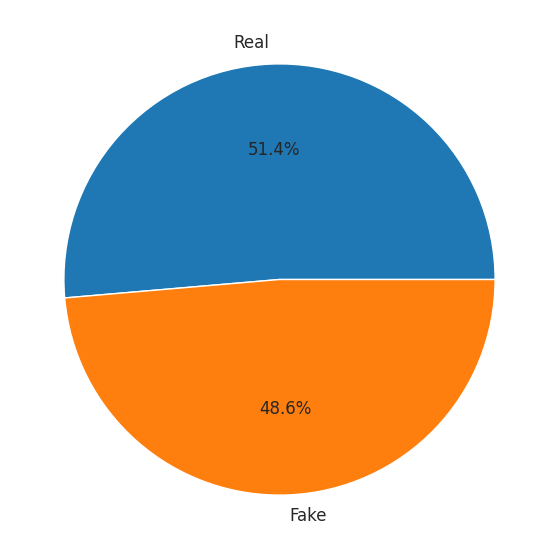

In [ ]:
df['real_fake'] = df['target'].apply(real_fake)
plt.pie(df['real_fake'].value_counts(), labels=df['real_fake'].unique().tolist(), autopct='%1.1f%%')
plt.show()

In [ ]:
def visualize(col):

    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=df[col], hue=df['real_fake'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)
    sns.kdeplot(x=df[col],hue=df['real_fake'])
    plt.legend(df['real_fake'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

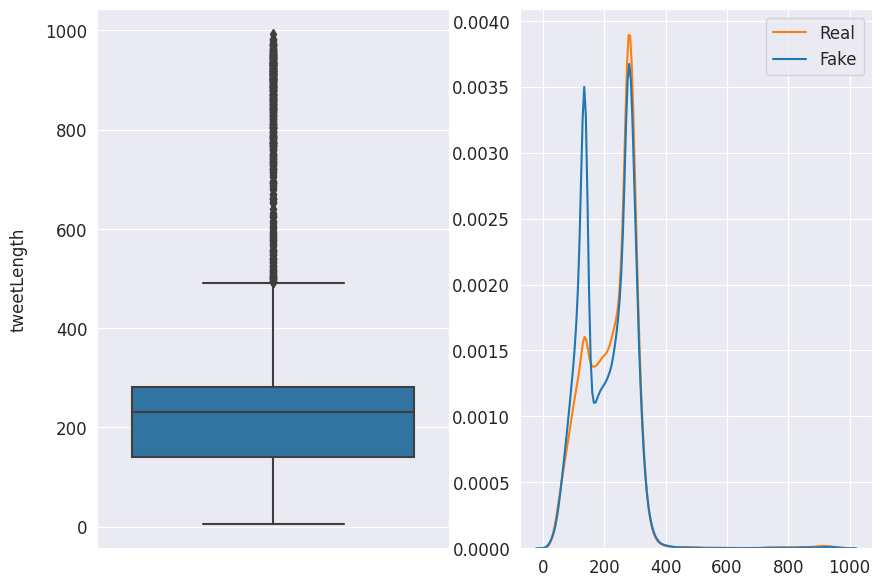

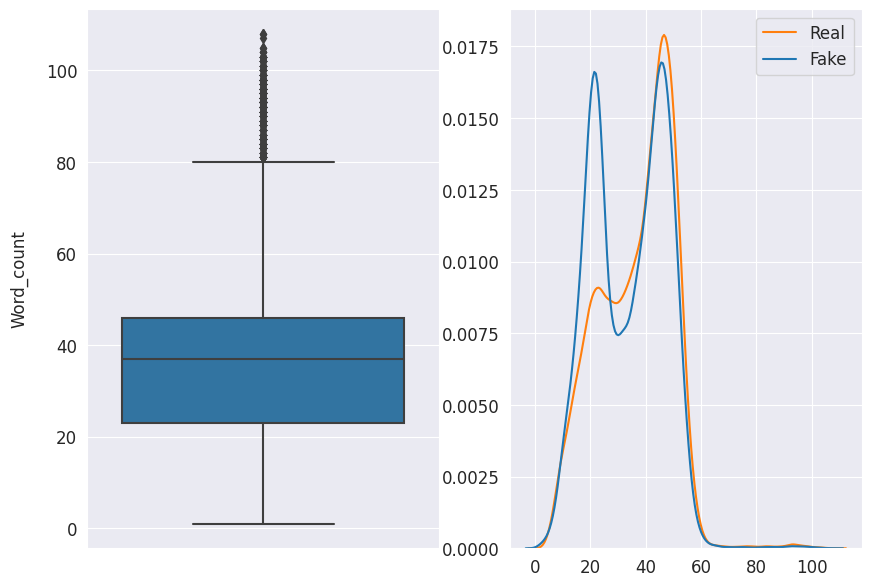

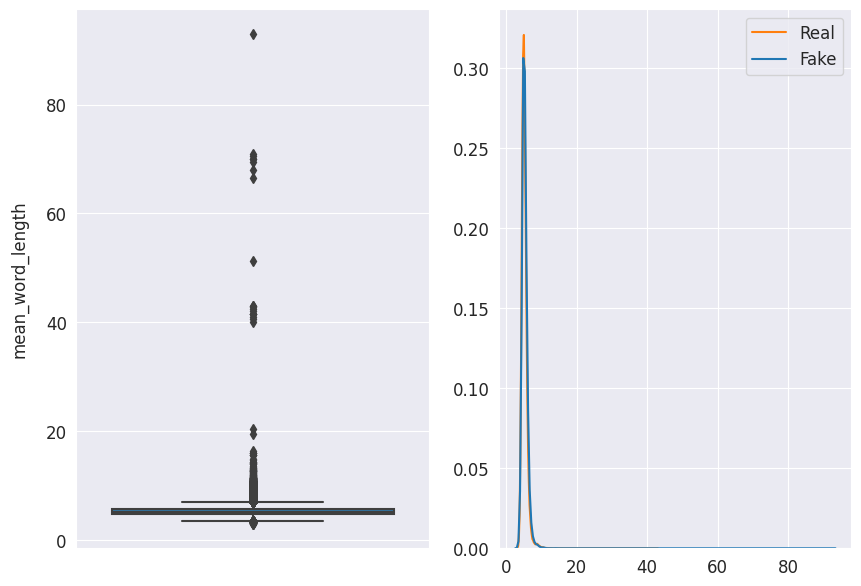

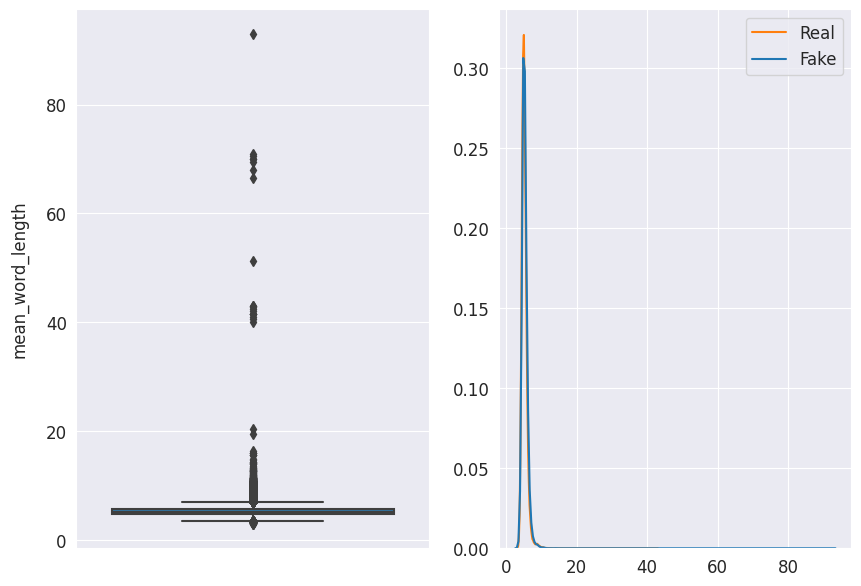

In [ ]:
features = ['tweetLength', 'Word_count', 'mean_word_length', 'mean_word_length']
for feature in features:
    visualize(feature)

In [ ]:
# Lowercase
# Remove punctutations
# Stopword removal

def clean(tweet):

    tweet = tweet.lower()
    tweet = re.sub('[^a-z A-Z 0-9- @]+', '', tweet)
    tweet = " ".join([word for word in tweet.split() if word not in stopwords.words('english')])

    return tweet

In [ ]:
df['tweet'] = df['tweet'].apply(clean)
df.head(10)

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,3_label_majority_answer,tweetLength,Word_count,mean_word_length,mean_sent_length,real_fake
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",potus biden blunders - 6 month updateinflation...,Agree,287,40,6.175000,287.000000,Real
1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",s0sickrick stairmaster 6d6f636869 many people ...,Agree,302,44,5.840909,74.250000,Real
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",supreme court siding super rich property owner...,Agree,221,35,5.342857,73.000000,Real
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",potus biden blundersbroken campaign promises i...,Agree,286,37,6.729730,286.000000,Real
4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",ohcomfy agree confluence events right unpreced...,Agree,239,35,5.857143,79.000000,Real
5,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",ive said really incredibly way afghanistan com...,Agree,251,39,5.461538,251.000000,Real
6,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",many face backlogged rent payments americans o...,Agree,279,43,5.511628,279.000000,Real
7,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",thomas1774paine joebidendojthejusticedeptinstr...,Agree,259,30,7.566667,21.083333,Real
8,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",socialismisdone theekhivequeenb win americansi...,Agree,168,24,6.041667,83.500000,Real
9,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",daysofarelives2 senjoemanchin never stimulus c...,Agree,306,47,5.531915,152.500000,Real


## **Modeling**

### Creating the Dataset

In [ ]:
!pip install git+https://github.com/huggingface/transformers

In [8]:
data = pd.read_csv("/content/Tweets-Classifiee/TruthSeeker2023/CleanData.csv")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               134198 non-null  int64  
 1   author                   134198 non-null  object 
 2   statement                134198 non-null  object 
 3   target                   134198 non-null  bool   
 4   BinaryNumTarget          134198 non-null  float64
 5   manual_keywords          134198 non-null  object 
 6   tweet                    134198 non-null  object 
 7   3_label_majority_answer  134198 non-null  object 
 8   tweetLength              134198 non-null  int64  
 9   Word_count               134198 non-null  int64  
 10  mean_word_length         134198 non-null  float64
 11  mean_sent_length         134198 non-null  float64
 12  real_fake                134198 non-null  object 
dtypes: bool(1), float64(3), int64(3), object(6)
memory usage: 1

In [11]:
requiredData = df[['statement', 'tweet','BinaryNumTarget']]

In [12]:
requiredData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   statement        134198 non-null  object 
 1   tweet            134198 non-null  object 
 2   BinaryNumTarget  134198 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.1+ MB


In [15]:
!pip install datasets

In [23]:
from datasets import Dataset
import torch

In [17]:
dataset  = Dataset.from_dict(requiredData.to_dict(orient='list'))

In [18]:
dataset

Dataset({
    features: ['statement', 'tweet', 'BinaryNumTarget'],
    num_rows: 134198
})

### Setup for the Modeling

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [22]:
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from transformers import (
    AdamW,
    BertTokenizer, BertForSequenceClassification
)
from tqdm.auto import tqdm

In [24]:
from torch.utils.data import Dataset

class TransDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        text_max_token_len: int = 100,
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        text = data_row["tweet"]
        target = data_row["BinaryNumTarget"]  # Assuming 'BinaryNumTarget' column contains binary labels (0 or 1)

        text_encoding = self.tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        return {
            'input_ids': text_encoding["input_ids"].flatten(),
            'attention_mask': text_encoding["attention_mask"].flatten(),
            'labels': torch.tensor(target, dtype=torch.long)  # Assuming 'Target' column contains 0 or 1
        }


In [25]:
class TransDataModule(pl.LightningDataModule):
  def __init__(
      self,
      train_df:pd.DataFrame,
      test_df:pd.DataFrame,
      tokenizer:BertTokenizer,
      text_max_token_len : int=100,
      code_max_token_len : int=175,  ### Cuda issue 1024 , decrese
      batch_size : int=8

  ):
    super().__init__()
    self.tokenizer = tokenizer
    self.train_df = train_df
    self.test_df = test_df
    self.text_max_token_len = text_max_token_len

    self.batch_size = batch_size
  def setup(self,stage = None):
    self.train_dataset = TransDataset(self.train_df,self.tokenizer,self.text_max_token_len)
    self.test_dataset = TransDataset(self.test_df,self.tokenizer,self.text_max_token_len)
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size = self.batch_size,
        shuffle= True,
        num_workers=2

    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size,
        shuffle= False,
        num_workers=2

    )
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size,
        shuffle= False,
        num_workers=2

    )